In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
import sys
sys.path.append("../")
from simulator.lensing import LensingSim

In [10]:
# Don't worry about these
exposure = 1610.0
n_xy = 64
pixel_size = 0.1
mag_zero=25.5
mag_iso=29.5
mag_s = 26.5
fwhm_psf = 0.18

coordinate_limit = pixel_size * n_xy / 2.0
f_iso = LensingSim._mag_to_flux(mag_iso, mag_zero)
S_tot = LensingSim._mag_to_flux(mag_s, mag_zero)

observation_dict = {
    "n_x": n_xy,
    "n_y": n_xy,
    "theta_x_lims": (-coordinate_limit, coordinate_limit),
    "theta_y_lims": (-coordinate_limit, coordinate_limit),
    "exposure": exposure,
    "f_iso": f_iso,
}

### Can play around with changing these ###

# Size of source
theta_s_e = 0.8

# Redshift (distance) of source and lens
global_dict = {"z_s": 1., "z_l": 0.2}

# theta_x_0 and theta_y_0 are the position of lens, theta_E is its size, q is its ellipticity
hst_param_dict = {"profile": "SIE", "theta_x_0": 0.12, "theta_y_0": -0.2, "theta_E": 2.15, "q": 0.8}

###########################################

src_param_dict = {"profile": "Sersic", "theta_x_0": 0., "theta_y_0": 0., "S_tot": S_tot, "theta_e": theta_s_e,"n_srsc": 1}    

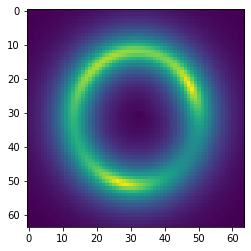

In [11]:
# Lensed image

lens_list = [hst_param_dict]
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image = lsi.lensed_image()

plt.imshow(image)

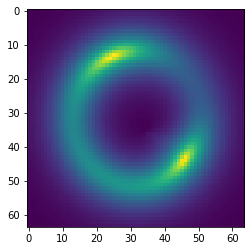

In [12]:
# Change the lens position

hst_param_dict = {"profile": "SIE", "theta_x_0": 0.3, "theta_y_0": 0.4, "theta_E": 2.15, "q": 0.8}

lens_list = [hst_param_dict]
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image = lsi.lensed_image()

plt.imshow(image)

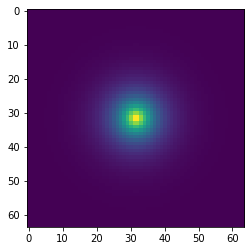

In [13]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image_nolens = lsi.lensed_image()

plt.imshow(image_nolens)

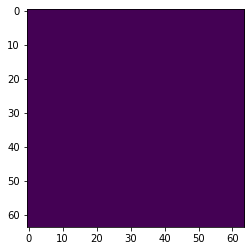

In [14]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [], global_dict, observation_dict)
image_nosrc = lsi.lensed_image()

plt.imshow(image_nosrc)

In [15]:
np.max(image_nolens - image_nosrc)

DeviceArray(3.86524581, dtype=float64)

## Custom source

In [16]:
import sys
sys.path.append("../")

from simulator.profiles import LightProfileSersic


In [17]:
# theta_x_lims = theta_y_lims = [-1.5, 1.5]
# n_x = n_y = 64

# theta_x, theta_y = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_x), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_y))

# inputs = LightProfileSersic(x_0=0.3, y_0=0., S_tot=5., r_e=1., n_srsc=4,).flux(theta_x, theta_y)

In [18]:
from jax import vmap
from einops import rearrange, repeat

In [19]:
# Lensed image

def render_lens(inputs):
    lens_list = [hst_param_dict]
    src_param_dict = {"profile": "CartesianGrid", "src_ary": inputs}    

    lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
    image = lsi.lensed_image()
    
    return image


# image = render_lens(inputs)

# plt.imshow(image)

In [20]:
render_lens_vmapped = vmap(render_lens)

# render_lens_vmapped(repeat(inputs, "h w -> b h w", b=128)).shape

## NeRF

In [41]:
def positional_encoding(inputs, positional_encoding_dims=2):
    batch_size, _ = inputs.shape
    # Applying vmap transform to vectorize the multiplication operation
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

In [42]:
# gamma = positional_encoding(rearrange(jnp.expand_dims(img_src, 0), "b h w -> b (h w)"))

In [43]:
from typing import Any

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

In [53]:
num_dense_layers = 4
dense_layer_width = 128

In [54]:
class NeRFModel(nn.Module):
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, input_points):
        for i in range(num_dense_layers):
            # Apply positional encoding to the input points
            x = positional_encoding(input_points)
                        
            # Fully-connected layer
            x = nn.Dense(
                dense_layer_width,
                dtype=self.dtype,
            )(x)
                        
            # Activation function
            x = nn.gelu(x)
            # Skip connection
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x

        x = nn.Dense(n_xy * n_xy, dtype=self.dtype)(x)
        return x


In [55]:
def initialize_model(key, input_pts_shape):
    # Create an instance of the model
    model = NeRFModel()

    # Initialize the model parameters
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    
    return model, initial_params["params"]

In [56]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(0))

# Initialize the Model
model, params = initialize_model(key, (1, 2 * n_xy * n_xy))

In [57]:
input_to_network = jnp.ones((1, 2 * 64 * 64))

In [58]:
model.apply({"params": params}, input_to_network).shape

(1, 4096)

In [59]:
model_fn = lambda x: model.apply({"params": params}, x)
model_output = model_fn(input_to_network)
model_output.shape

(1, 4096)

In [60]:
def train_step(state, batch):
    """Train Step"""
    # Unravel the inputs and targets from the batch
    inputs, targets = batch
    inputs = rearrange(inputs, "c h w -> 1 (c h w)")
                       
    # Compute the loss in a stateless manner
    def loss_fn(params):
        # Create the model function from the train state
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        model_output = model_fn(inputs)
        model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)

        lenses = render_lens_vmapped(model_output)
        # Compute mean-squared error
        loss_mse = jnp.mean((lenses - targets) ** 2)
        return loss_mse
    
    # Transform the loss function to get the loss value and the gradients
    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    # Updated the model params and the optimizer state
    new_state = state.apply_gradients(grads=gradients)
    # Mean of train loss of the batch
    train_loss = jnp.mean(train_loss)
    # Compute PSNR
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    return train_loss, train_psnr, new_state 

In [61]:
learning_rate = 1e-3

In [62]:
coords = jnp.array([lsi.theta_x, lsi.theta_y])
image_input =  jnp.expand_dims(image, 0)  # jnp.expand_dims((image - jnp.mean(image)) / jnp.std(image), 0)

In [63]:
train_epochs = 1000

In [64]:
coords.shape, image_input.shape

((2, 64, 64), (1, 64, 64))

In [65]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(0))

# Initialize the Model
model, params = initialize_model(key, (1, 2 * n_xy * n_xy))

# Define the Optimizer
optimizer = optax.adam(learning_rate=learning_rate)

# Create the Training State
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer
)

# Function for executing the train and validation loop
def train_and_evaluate(state, train_step_fn):
    
    train_loss_history, train_psnr_history = [], []
    
    for epoch in tqdm(range(train_epochs)):
                
        train_batch = coords, image_input

        # Perform the Training Step
        train_loss, train_psnr, state = train_step_fn(state, train_batch)
                      
        train_loss_history.append(np.asarray(np.mean(train_loss)))
        train_psnr_history.append(np.asarray(np.mean(train_psnr)))

        # Plot the result every plot interval
        if epoch % 25 == 0:    
            
            model_fn = lambda x: state.apply_fn({"params": state.params}, x)
            model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
            model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)
            
            lenses = render_lens_vmapped(model_output)
            
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
            ax1.imshow(model_output[0])
            ax1.set_title(f"Predicted source at epoch {epoch}")
            ax1.axis("off")
            ax2.imshow(image_nolens)
            ax2.set_title(f"True source")
            ax2.axis("off")
            ax3.imshow(lenses[0])
            ax3.set_title(f"Predicted lensed image at epoch {epoch}")
            ax3.axis("off")
            ax4.imshow(image_input[0])
            ax4.set_title(f"True lensed image")
            ax4.axis("off")
            plt.show()
            
    
    history = {
        "train_loss": train_loss_history,
        "train_psnr": train_psnr_history,
    }
    
    return state, history

  0%|          | 0/1000 [00:00<?, ?it/s]

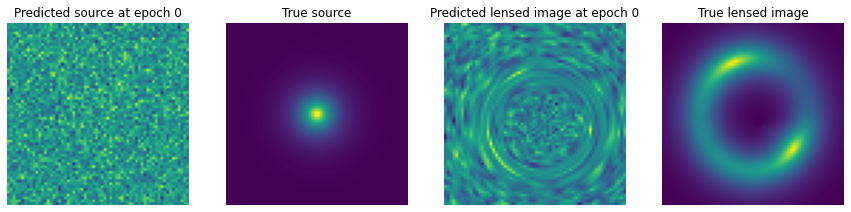

  2%|▎         | 25/1000 [00:12<06:14,  2.60it/s]

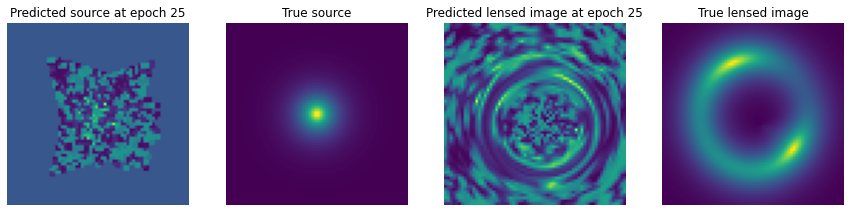

  5%|▌         | 50/1000 [00:22<05:54,  2.68it/s]

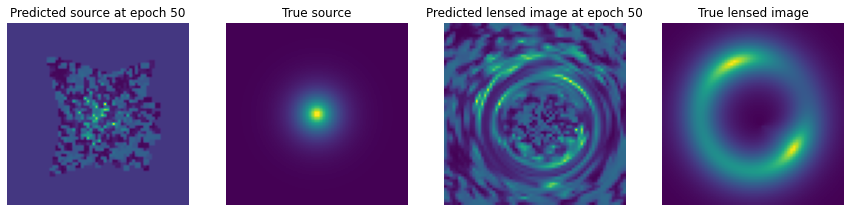

  8%|▊         | 75/1000 [00:32<06:54,  2.23it/s]

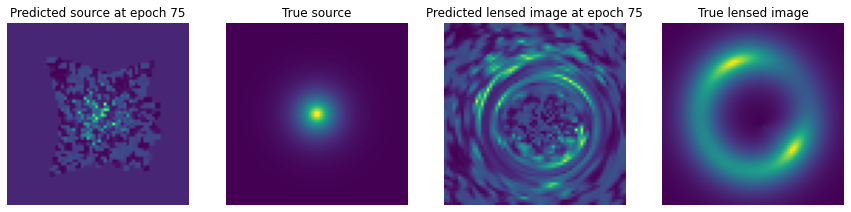

 10%|█         | 100/1000 [00:42<05:35,  2.69it/s]

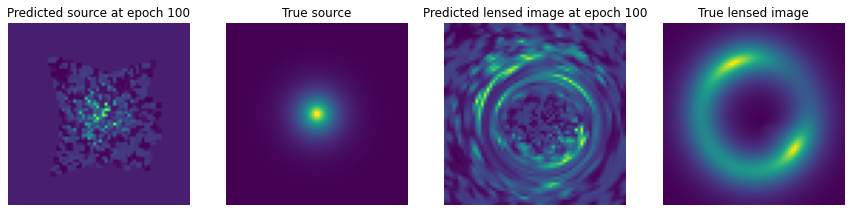

 12%|█▎        | 125/1000 [00:51<05:31,  2.64it/s]

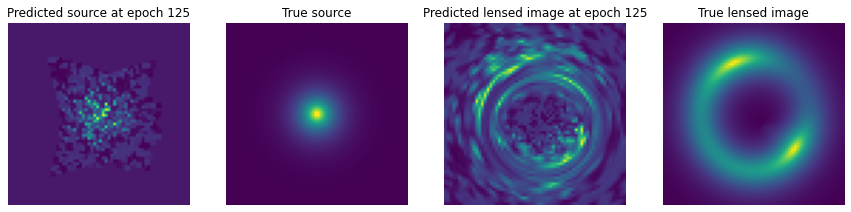

 15%|█▌        | 150/1000 [01:02<05:19,  2.66it/s]

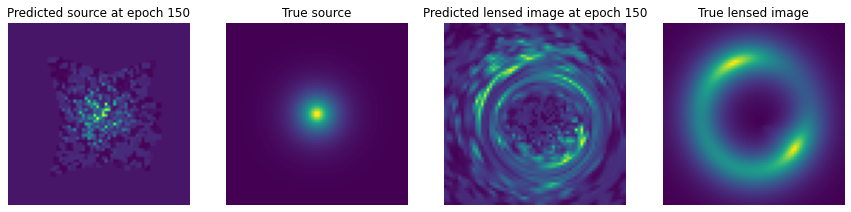

 18%|█▊        | 175/1000 [01:11<05:09,  2.67it/s]

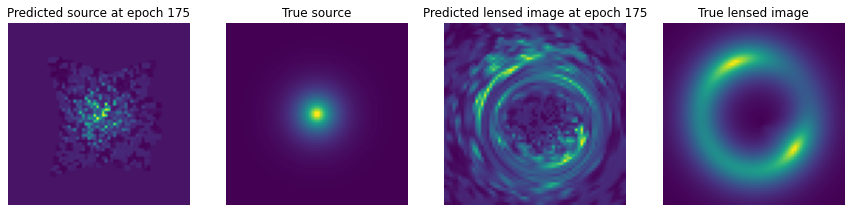

 20%|██        | 200/1000 [01:21<05:10,  2.58it/s]

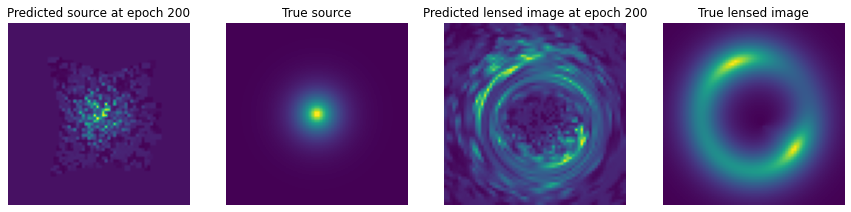

 22%|██▎       | 225/1000 [01:31<04:51,  2.66it/s]

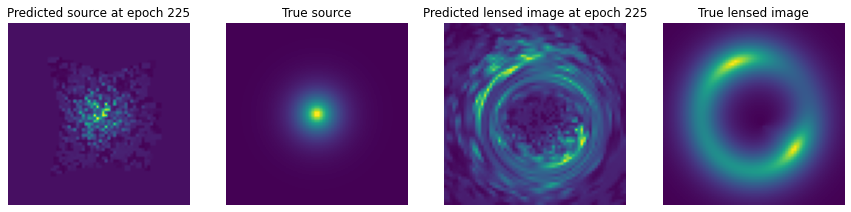

 25%|██▌       | 250/1000 [01:41<04:42,  2.66it/s]

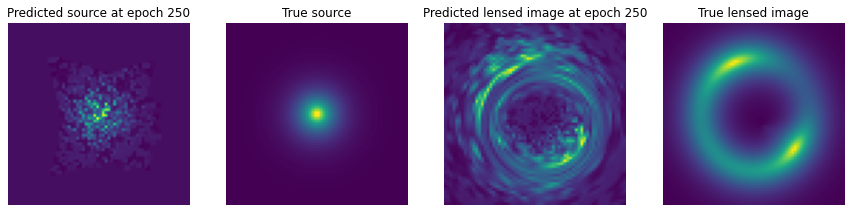

 28%|██▊       | 275/1000 [01:52<04:44,  2.54it/s]

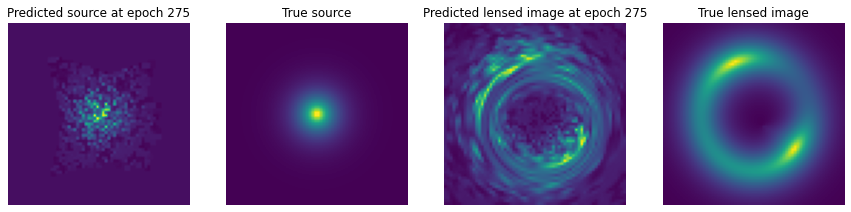

 30%|███       | 300/1000 [02:02<04:24,  2.65it/s]

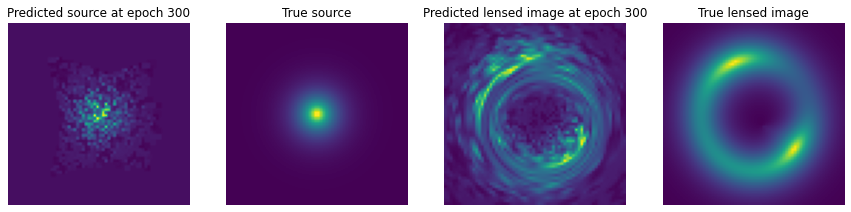

 32%|███▎      | 325/1000 [02:12<04:15,  2.65it/s]

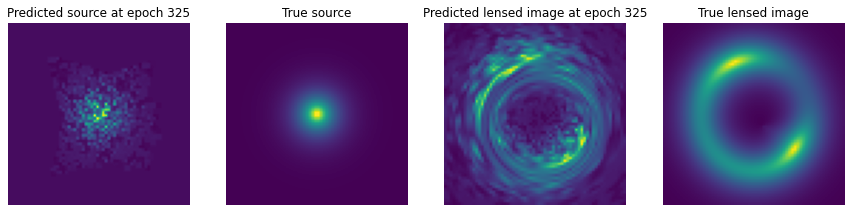

 35%|███▌      | 350/1000 [02:22<04:11,  2.59it/s]

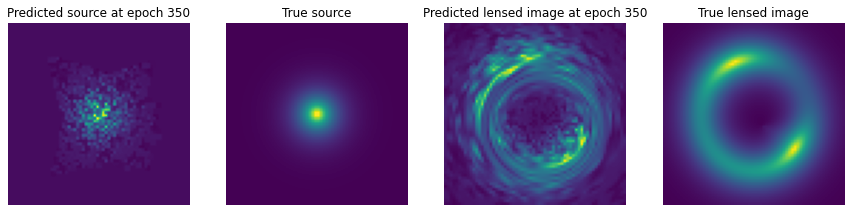

 38%|███▊      | 375/1000 [02:32<03:57,  2.63it/s]

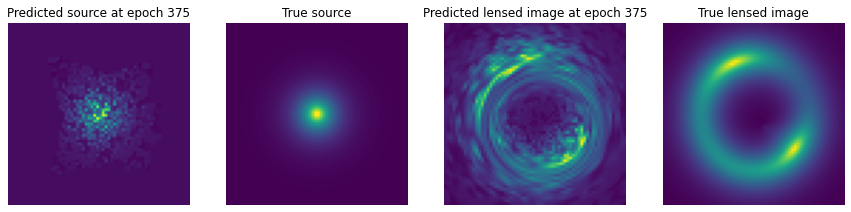

 40%|████      | 400/1000 [02:42<03:48,  2.63it/s]

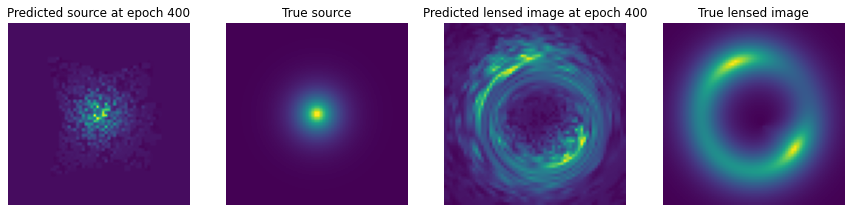

 42%|████▎     | 425/1000 [02:53<04:03,  2.36it/s]

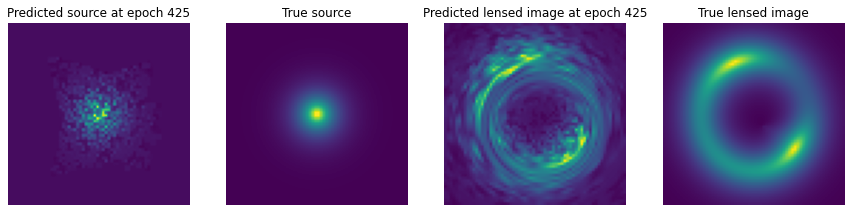

 45%|████▌     | 450/1000 [03:03<03:31,  2.60it/s]

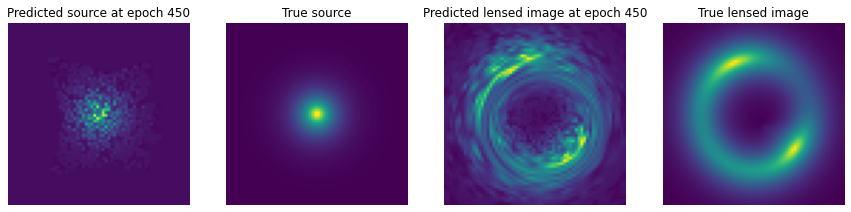

 48%|████▊     | 475/1000 [03:13<03:23,  2.58it/s]

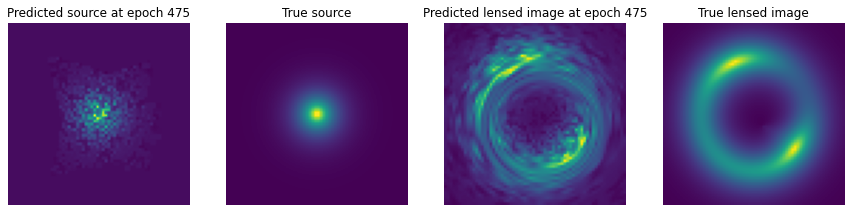

 50%|█████     | 500/1000 [03:26<04:16,  1.95it/s]

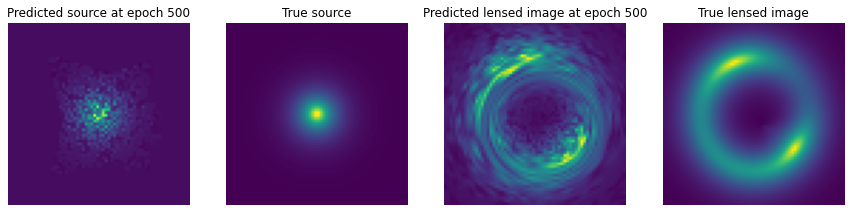

 52%|█████▎    | 525/1000 [03:39<04:02,  1.96it/s]

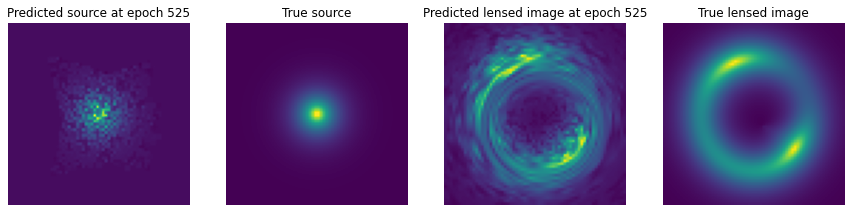

 55%|█████▌    | 550/1000 [03:52<03:52,  1.93it/s]

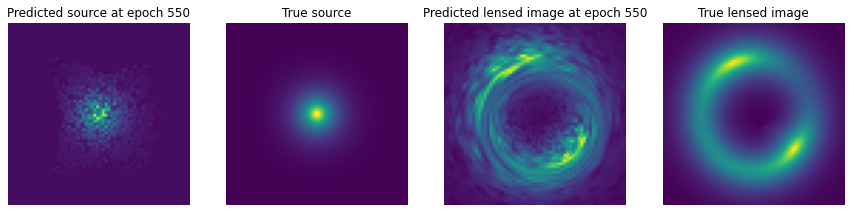

 57%|█████▊    | 575/1000 [04:06<03:42,  1.91it/s]

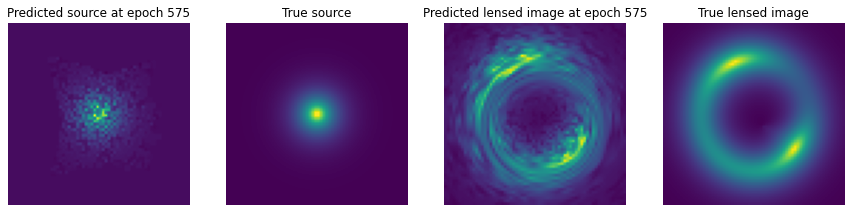

 60%|██████    | 600/1000 [04:19<03:26,  1.93it/s]

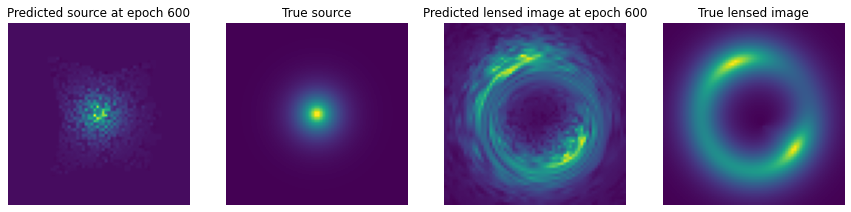

 62%|██████▎   | 625/1000 [04:33<03:13,  1.94it/s]

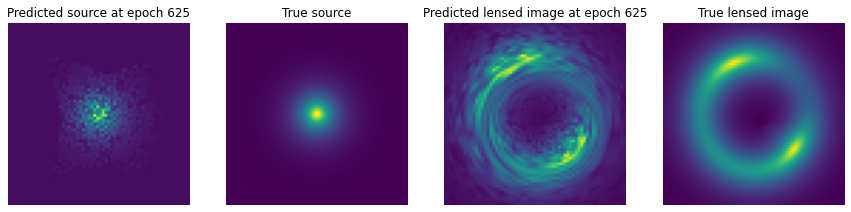

 65%|██████▌   | 650/1000 [04:46<03:01,  1.93it/s]

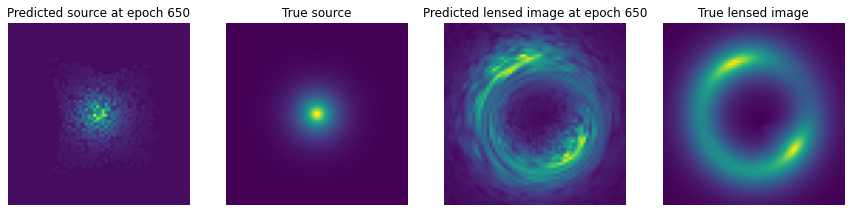

 68%|██████▊   | 675/1000 [05:00<02:51,  1.89it/s]

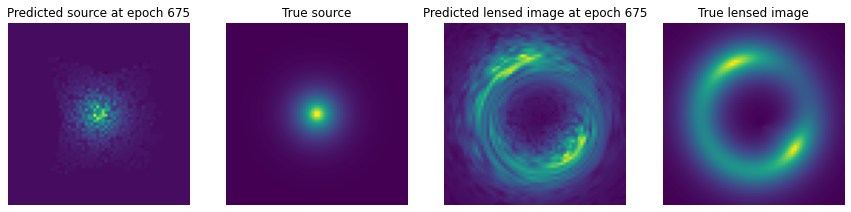

 70%|███████   | 700/1000 [05:14<02:36,  1.91it/s]

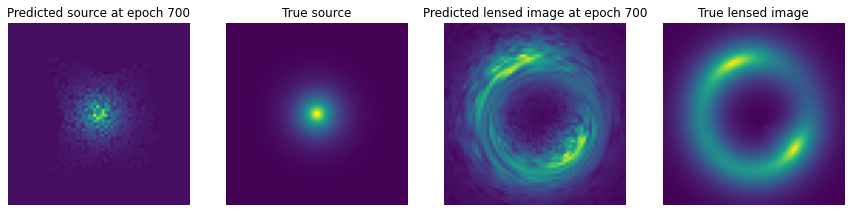

 72%|███████▎  | 725/1000 [05:27<02:23,  1.91it/s]

In [ ]:
state, history = train_and_evaluate(state, train_step)

In [ ]:
history["train_loss"]

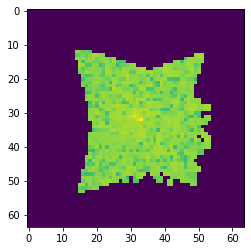

In [34]:
model_fn = lambda x: state.apply_fn({"params": state.params}, x)
model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)
plt.imshow(model_output[0])

In [38]:
model_output[0].max()

DeviceArray(0.1005477, dtype=float32)